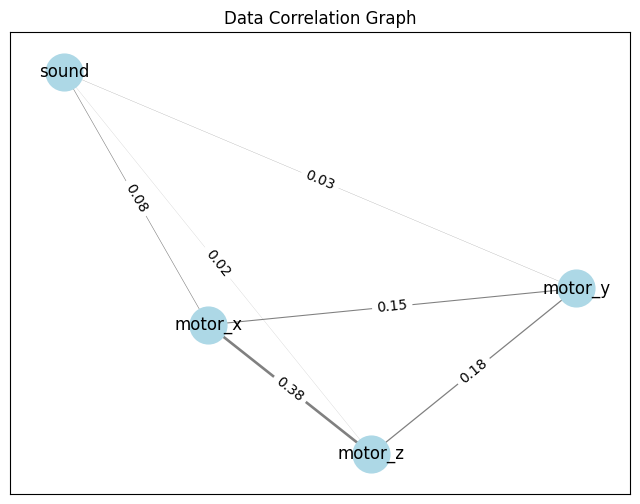

In [3]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.data import Data
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx

# 파일 경로 설정
normal_file_path = './csv/5000hz/300rpm/300rpm normal data/stream2024_4_22_23_23.csv'

# CSV 파일 읽기
normal_df = pd.read_csv(normal_file_path)

# 상관 행렬 계산
corr_matrix = normal_df[['motor1_x', 'motor1_y', 'motor1_z', 'sound']].corr().values

# 상관계수 임계값 설정
threshold = 0  # 임계값을 0으로 설정하여 모든 관계 포함
edges = np.where(np.abs(corr_matrix) > threshold)

# 노드 이름 설정
node_labels = ['motor_x', 'motor_y', 'motor_z', 'sound']

# 그래프 생성
G = nx.Graph()

# 노드 추가
for node in node_labels:
    G.add_node(node)

# 엣지 추가
for i in range(len(edges[0])):
    if edges[0][i] != edges[1][i]:  # 자기 자신과의 엣지 제외
        G.add_edge(node_labels[edges[0][i]], node_labels[edges[1][i]], weight=np.abs(corr_matrix[edges[0][i], edges[1][i]]))

# 그래프 시각화
pos = nx.spring_layout(G, seed=42)  # 노드 배치 설정
plt.figure(figsize=(8, 6))

# 노드 그리기
nx.draw_networkx_nodes(G, pos, node_size=700, node_color='lightblue')
# 엣지 그리기 (엣지 두께는 상관계수 크기에 비례)
edges = nx.draw_networkx_edges(G, pos, edge_color='gray', width=[G[u][v]['weight']*5 for u,v in G.edges()])
# 라벨 그리기
nx.draw_networkx_labels(G, pos, font_size=12, font_family="sans-serif")
# 엣지 라벨 그리기 (상관계수)
edge_labels = nx.get_edge_attributes(G, 'weight')
edge_labels = {k: f'{v:.2f}' for k, v in edge_labels.items()}
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=10)

plt.title("Data Correlation Graph")
plt.show()

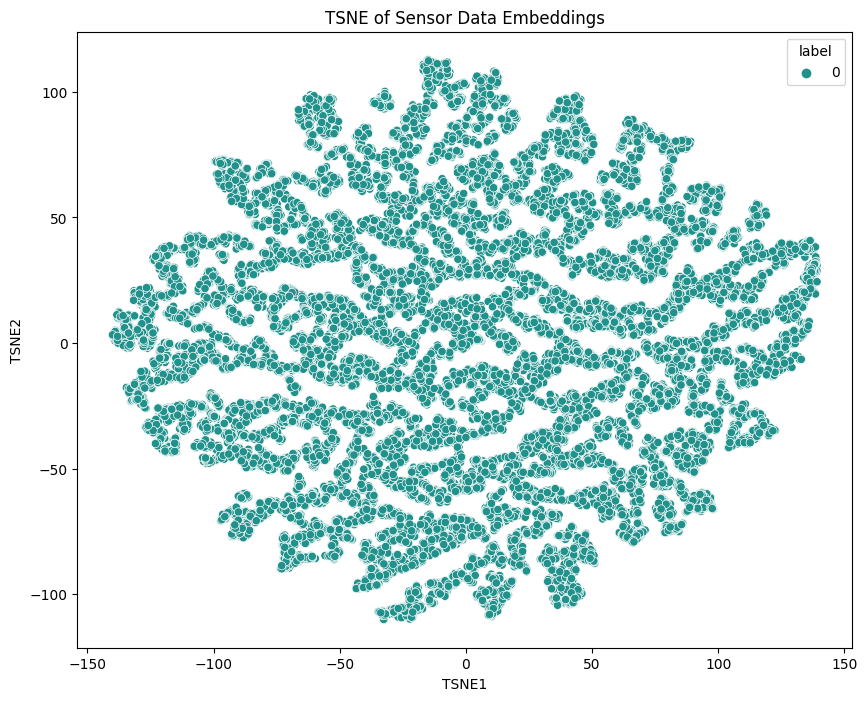

In [6]:
import pandas as pd
import numpy as np
import torch
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
import torch.nn.functional as F
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns

# 데이터 로드 및 레이블 추가
normal_df = pd.read_csv("./csv/5000hz/300rpm/300rpm normal data/stream2024_4_22_23_22.csv")
fault1_df = pd.read_csv("./csv/5000hz/300rpm/300rpm carriage damage/stream2024_4_23_2_56.csv")
fault2_df = pd.read_csv("./csv/5000hz/300rpm/300rpm high-speed damage/stream2024_4_23_0_20.csv")
fault3_df = pd.read_csv("./csv/5000hz/300rpm/300rpm lack of lubrication/stream2024_4_23_2_6.csv")
fault4_df = pd.read_csv("./csv/5000hz/300rpm/300rpm oxidation and corrosion/stream2024_4_23_1_15.csv")

normal_df['label'] = 0
fault1_df['label'] = 1
fault2_df['label'] = 2
fault3_df['label'] = 3
fault4_df['label'] = 4

# 데이터 결합
data_df = pd.concat([normal_df, fault1_df, fault2_df, fault3_df, fault4_df], ignore_index=True)

# 시계열 데이터를 윈도우로 분할
def create_windows(data, window_size, stride):
    windows = []
    for i in range(0, len(data) - window_size + 1, stride):
        window = data[i:i + window_size].flatten()  # 윈도우 내 데이터를 일렬로 펼침
        windows.append(window)
    return np.array(windows)

window_size = 100
stride = 50
features = create_windows(data_df[['motor1_x', 'motor1_y', 'motor1_z', 'sound']].values, window_size, stride)

# 노드 특성 정규화
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# KNN을 사용하여 엣지 생성
k = 5
knn = NearestNeighbors(n_neighbors=k).fit(features_scaled)
distances, indices = knn.kneighbors(features_scaled)

edge_index = []
for i in range(indices.shape[0]):
    for j in range(1, k):
        edge_index.append([i, indices[i, j]])

edge_index = np.array(edge_index).T

# 그래프 데이터 객체 생성
x = torch.tensor(features_scaled, dtype=torch.float)
edge_index = torch.tensor(edge_index, dtype=torch.long)
data = Data(x=x, edge_index=edge_index)

# GNN 모델 정의
class GCN(torch.nn.Module):
    def __init__(self, num_node_features):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(num_node_features, 16)
        self.conv2 = GCNConv(16, 2)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        return x

# 모델 학습
num_node_features = x.shape[1]
model = GCN(num_node_features)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
model.train()
for epoch in range(200):
    optimizer.zero_grad()
    out = model(data)
    node_embeddings = out
    dummy_labels = torch.zeros(data.num_nodes, dtype=torch.long)  # 더미 레이블
    loss = F.cross_entropy(node_embeddings, dummy_labels)
    loss.backward()
    optimizer.step()

# 학습된 모델을 사용하여 노드 임베딩 추출
model.eval()
node_embeddings = model(data).detach().numpy()

# TSNE를 사용하여 임베딩 축소 및 시각화
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
embeddings_2d = tsne.fit_transform(node_embeddings)

# TSNE로 임베딩된 2D 좌표에 레이블 추가
labels = data_df['label'].values[:len(embeddings_2d)]  # TSNE 임베딩 수에 맞게 레이블 가져오기
df_embeddings = pd.DataFrame(embeddings_2d, columns=['TSNE1', 'TSNE2'])
df_embeddings['label'] = labels

# TSNE 시각화
plt.figure(figsize=(10, 8))
sns.scatterplot(data=df_embeddings, x='TSNE1', y='TSNE2', hue='label', palette='viridis', legend='full')
plt.title("TSNE of Sensor Data Embeddings")
plt.show()

In [7]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, VGAE
from torch_geometric.data import Data
from torch_geometric.utils import train_test_split_edges
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from scipy.signal import stft
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import classification_report, accuracy_score, f1_score

# 데이터 파일 로드 및 정규화
def normalize_data(df):
    scaler = StandardScaler()
    return scaler.fit_transform(df)

def load_and_normalize_data(filenames, label):
    data_list = []
    for filename in filenames:
        df = pd.read_csv(filename)
        motor_data_normalized = normalize_data(df[['motor1_x', 'motor1_y', 'motor1_z']])
        sound_data_normalized = normalize_data(df[['sound']])
        data_list.append((motor_data_normalized, sound_data_normalized, label))
    return data_list

normal_files = ["./csv/5000hz/300rpm/300rpm normal data/stream2024_4_22_23_22.csv"]
fault1_files = ["./csv/5000hz/300rpm/300rpm carriage damage/stream2024_4_23_2_56.csv"]
fault2_files = ["./csv/5000hz/300rpm/300rpm high-speed damage/stream2024_4_23_0_20.csv"]
fault3_files = ["./csv/5000hz/300rpm/300rpm lack of lubrication/stream2024_4_23_2_6.csv"]
fault4_files = ["./csv/5000hz/300rpm/300rpm oxidation and corrosion/stream2024_4_23_1_15.csv"]

data_normal = load_and_normalize_data(normal_files, 0)
data_fault1 = load_and_normalize_data(fault1_files, 1)
data_fault2 = load_and_normalize_data(fault2_files, 2)
data_fault3 = load_and_normalize_data(fault3_files, 3)
data_fault4 = load_and_normalize_data(fault4_files, 4)

all_data = data_normal + data_fault1 + data_fault2 + data_fault3 + data_fault4

# 시계열 데이터를 윈도우로 분할
def create_windows(data, window_size, stride):
    windows = []
    labels = []
    for (motor_data, sound_data, label) in data:
        combined_data = np.hstack([motor_data, sound_data])
        for i in range(0, len(combined_data) - window_size + 1, stride):
            window = combined_data[i:i + window_size, :]
            windows.append(window)
            labels.append(label)
    return np.array(windows), np.array(labels)

window_size = 100
stride = 50
features, labels = create_windows(all_data, window_size, stride)

# STFT 변환 함수
def apply_stft(windows, nperseg=50):
    stft_windows = []
    for window in windows:
        stft_result = []
        for signal in window.T:
            f, t, Zxx = stft(signal, nperseg=min(len(signal), nperseg))
            stft_result.append(np.abs(Zxx))
        stft_windows.append(np.array(stft_result))
    return np.array(stft_windows)

# STFT 변환 적용
stft_features = apply_stft(features)

# STFT 결과를 (samples, time, features) 형태로 변환
stft_features = stft_features.transpose(0, 2, 1, 3)  # (samples, time, features)

# 노드 특성 정규화
scaler = StandardScaler()
features_scaled = scaler.fit_transform(stft_features.reshape(stft_features.shape[0], -1))

# KNN을 사용하여 엣지 생성
k = 5
knn = NearestNeighbors(n_neighbors=k).fit(features_scaled)
distances, indices = knn.kneighbors(features_scaled)

edge_index = []
for i in range(indices.shape[0]):
    for j in range(1, k):
        edge_index.append([i, indices[i, j]])

edge_index = np.array(edge_index).T

# 그래프 데이터 객체 생성
x = torch.tensor(features_scaled, dtype=torch.float)
edge_index = torch.tensor(edge_index, dtype=torch.long)
data = Data(x=x, edge_index=edge_index)

# 그래프 데이터 분할
data = train_test_split_edges(data)

# GraphVAE 모델 정의
class GraphVAE(VGAE):
    def __init__(self, in_channels, out_channels):
        encoder = torch.nn.ModuleList([
            GCNConv(in_channels, 16),
            GCNConv(16, out_channels)
        ])
        super(GraphVAE, self).__init__(encoder)
        self.conv1 = encoder[0]
        self.conv2 = encoder[1]
        self.__mu__ = None
        self.__logstd__ = None

    def encode(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        self.__mu__ = self.conv2(x, edge_index)
        self.__logstd__ = torch.zeros_like(self.__mu__)
        return self.__mu__

# 모델 학습
in_channels = x.shape[1]
out_channels = 2
model = GraphVAE(in_channels, out_channels)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
model.train()
for epoch in range(200):
    optimizer.zero_grad()
    z = model.encode(data.x, data.train_pos_edge_index)
    loss = model.recon_loss(z, data.train_pos_edge_index)
    loss = loss + (1 / data.num_nodes) * model.kl_loss()
    loss.backward()
    optimizer.step()

    print(f'Epoch {epoch+1}, Loss: {loss.item():.4f}')

# 학습된 모델을 사용하여 노드 임베딩 추출
model.eval()
with torch.no_grad():
    z = model.encode(data.x, data.test_pos_edge_index)
    auc, ap = model.test(z, data.test_pos_edge_index, data.test_neg_edge_index)
    print(f'AUC: {auc:.4f}, AP: {ap:.4f}')

    # 테스트 엣지의 예측값을 얻습니다.
    pos_pred = model.decode(z, data.test_pos_edge_index).view(-1).cpu().numpy()
    neg_pred = model.decode(z, data.test_neg_edge_index).view(-1).cpu().numpy()

    # 실제 라벨 생성 (양성은 1, 음성은 0)
    y_true = np.concatenate([np.ones(pos_pred.shape[0]), np.zeros(neg_pred.shape[0])])
    y_pred = np.concatenate([pos_pred, neg_pred])

    # 이진 분류를 위한 최적 임계값을 정하고 이를 기준으로 예측값을 이진화
    threshold = 0.5
    y_pred_binary = (y_pred > threshold).astype(int)

    # F1 스코어 계산
    f1 = f1_score(y_true, y_pred_binary)
    print(f'F1 Score: {f1:.4f}')

/Users/kimdozz0/Library/Python/3.9/lib/python/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'train_test_split_edges' is deprecated, use 'transforms.RandomLinkSplit' instead
  warnings.warn(out)


Epoch 1, Loss: 1.6261
Epoch 2, Loss: 1.5524
Epoch 3, Loss: 1.3141
Epoch 4, Loss: 1.3320
Epoch 5, Loss: 1.2553
Epoch 6, Loss: 1.2382
Epoch 7, Loss: 1.1857
Epoch 8, Loss: 1.1868
Epoch 9, Loss: 1.1876
Epoch 10, Loss: 1.1502
Epoch 11, Loss: 1.1816
Epoch 12, Loss: 1.1490
Epoch 13, Loss: 1.1260
Epoch 14, Loss: 1.1443
Epoch 15, Loss: 1.1151
Epoch 16, Loss: 1.0944
Epoch 17, Loss: 1.1129
Epoch 18, Loss: 1.0858
Epoch 19, Loss: 1.0881
Epoch 20, Loss: 1.0845
Epoch 21, Loss: 1.0635
Epoch 22, Loss: 1.0644
Epoch 23, Loss: 1.0643
Epoch 24, Loss: 1.0560
Epoch 25, Loss: 1.0530
Epoch 26, Loss: 1.0476
Epoch 27, Loss: 1.0397
Epoch 28, Loss: 1.0448
Epoch 29, Loss: 1.0377
Epoch 30, Loss: 1.0285
Epoch 31, Loss: 1.0397
Epoch 32, Loss: 1.0391
Epoch 33, Loss: 1.0275
Epoch 34, Loss: 1.0323
Epoch 35, Loss: 1.0393
Epoch 36, Loss: 1.0258
Epoch 37, Loss: 1.0328
Epoch 38, Loss: 1.0444
Epoch 39, Loss: 1.0197
Epoch 40, Loss: 1.0330
Epoch 41, Loss: 1.0470
Epoch 42, Loss: 1.0142
Epoch 43, Loss: 1.0559
Epoch 44, Loss: 1.06

In [8]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, VGAE
from torch_geometric.data import Data
from torch_geometric.utils import train_test_split_edges
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from scipy.signal import stft
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import classification_report, accuracy_score, f1_score
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
import torch.nn as nn

# 데이터 파일 로드 및 정규화
def normalize_data(df):
    scaler = StandardScaler()
    return scaler.fit_transform(df)

def load_and_normalize_data(filenames, label):
    data_list = []
    for filename in filenames:
        df = pd.read_csv(filename)
        motor_data_normalized = normalize_data(df[['motor1_x', 'motor1_y', 'motor1_z']])
        sound_data_normalized = normalize_data(df[['sound']])
        data_list.append((motor_data_normalized, sound_data_normalized, label))
    return data_list

normal_files = ["./csv/5000hz/300rpm/300rpm normal data/stream2024_4_22_23_22.csv"]
fault1_files = ["./csv/5000hz/300rpm/300rpm carriage damage/stream2024_4_23_2_56.csv"]
fault2_files = ["./csv/5000hz/300rpm/300rpm high-speed damage/stream2024_4_23_0_20.csv"]
fault3_files = ["./csv/5000hz/300rpm/300rpm lack of lubrication/stream2024_4_23_2_6.csv"]
fault4_files = ["./csv/5000hz/300rpm/300rpm oxidation and corrosion/stream2024_4_23_1_15.csv"]

data_normal = load_and_normalize_data(normal_files, 0)
data_fault1 = load_and_normalize_data(fault1_files, 1)
data_fault2 = load_and_normalize_data(fault2_files, 2)
data_fault3 = load_and_normalize_data(fault3_files, 3)
data_fault4 = load_and_normalize_data(fault4_files, 4)

all_data = data_normal + data_fault1 + data_fault2 + data_fault3 + data_fault4

# 시계열 데이터를 윈도우로 분할
def create_windows(data, window_size, stride):
    windows = []
    labels = []
    for (motor_data, sound_data, label) in data:
        combined_data = np.hstack([motor_data, sound_data])
        for i in range(0, len(combined_data) - window_size + 1, stride):
            window = combined_data[i:i + window_size, :]
            windows.append(window)
            labels.append(label)
    return np.array(windows), np.array(labels)

window_size = 100
stride = 50
features, labels = create_windows(all_data, window_size, stride)

# STFT 변환 함수
def apply_stft(windows, nperseg=50):
    stft_windows = []
    for window in windows:
        stft_result = []
        for signal in window.T:
            f, t, Zxx = stft(signal, nperseg=min(len(signal), nperseg))
            stft_result.append(np.abs(Zxx))
        stft_windows.append(np.array(stft_result))
    return np.array(stft_windows)

# STFT 변환 적용
stft_features = apply_stft(features)

# STFT 결과를 (samples, time, features) 형태로 변환
stft_features = stft_features.transpose(0, 2, 1, 3)  # (samples, time, features)

# 노드 특성 정규화
scaler = StandardScaler()
features_scaled = scaler.fit_transform(stft_features.reshape(stft_features.shape[0], -1))

# KNN을 사용하여 엣지 생성
k = 5
knn = NearestNeighbors(n_neighbors=k).fit(features_scaled)
distances, indices = knn.kneighbors(features_scaled)

edge_index = []
for i in range(indices.shape[0]):
    for j in range(1, k):
        edge_index.append([i, indices[i, j]])

edge_index = np.array(edge_index).T

# 그래프 데이터 객체 생성
x = torch.tensor(features_scaled, dtype=torch.float)
edge_index = torch.tensor(edge_index, dtype=torch.long)
data = Data(x=x, edge_index=edge_index)

# 그래프 데이터 분할
data = train_test_split_edges(data)

# GraphVAE 모델 정의
class GraphVAE(VGAE):
    def __init__(self, in_channels, out_channels):
        encoder = torch.nn.ModuleList([
            GCNConv(in_channels, 16),
            GCNConv(16, out_channels)
        ])
        super(GraphVAE, self).__init__(encoder)
        self.conv1 = encoder[0]
        self.conv2 = encoder[1]
        self.__mu__ = None
        self.__logstd__ = None

    def encode(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        self.__mu__ = self.conv2(x, edge_index)
        self.__logstd__ = torch.zeros_like(self.__mu__)
        return self.__mu__

# 모델 학습
in_channels = x.shape[1]
out_channels = 16  # 잠재 공간의 차원 수를 늘립니다.
model = GraphVAE(in_channels, out_channels)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
model.train()
for epoch in range(200):
    optimizer.zero_grad()
    z = model.encode(data.x, data.train_pos_edge_index)
    loss = model.recon_loss(z, data.train_pos_edge_index)
    loss = loss + (1 / data.num_nodes) * model.kl_loss()
    loss.backward()
    optimizer.step()

    print(f'Epoch {epoch+1}, Loss: {loss.item():.4f}')

# 학습된 모델을 사용하여 노드 임베딩 추출
model.eval()
with torch.no_grad():
    z = model.encode(data.x, data.test_pos_edge_index)

# 임베딩과 레이블 준비
X = z.cpu().numpy()
y = labels

# 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# ConvLSTM 모델 정의
class ConvLSTMCell(nn.Module):
    def __init__(self, input_dim, hidden_dim, kernel_size, bias):
        super(ConvLSTMCell, self).__init__()
        
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.kernel_size = kernel_size
        self.padding = kernel_size // 2
        self.bias = bias
        
        self.conv = nn.Conv2d(in_channels=self.input_dim + self.hidden_dim,
                              out_channels=4 * self.hidden_dim,
                              kernel_size=self.kernel_size,
                              padding=self.padding,
                              bias=self.bias)

    def forward(self, input_tensor, cur_state):
        h_cur, c_cur = cur_state
        
        combined = torch.cat([input_tensor, h_cur], dim=1)  # concatenate along channel axis
        combined_conv = self.conv(combined)
        cc_i, cc_f, cc_o, cc_g = torch.split(combined_conv, self.hidden_dim, dim=1)
        i = torch.sigmoid(cc_i)
        f = torch.sigmoid(cc_f)
        o = torch.sigmoid(cc_o)
        g = torch.tanh(cc_g)
        
        c_next = f * c_cur + i * g
        h_next = o * torch.tanh(c_next)
        
        return h_next, c_next

    def init_hidden(self, batch_size, image_size):
        height, width = image_size
        return (torch.zeros(batch_size, self.hidden_dim, height, width, device=self.conv.weight.device),
                torch.zeros(batch_size, self.hidden_dim, height, width, device=self.conv.weight.device))

class ConvLSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, kernel_size, num_classes, bias=True):
        super(ConvLSTM, self).__init__()

        self.conv_lstm_cell = ConvLSTMCell(input_dim, hidden_dim, kernel_size, bias)
        self.fc = nn.Linear(hidden_dim * input_dim, num_classes)  # hidden_dim * input_dim 크기 변경
    
    def forward(self, x):
        batch_size, seq_len, height, width = x.size()
        h, c = self.conv_lstm_cell.init_hidden(batch_size, (height, width))
        
        for t in range(seq_len):
            h, c = self.conv_lstm_cell(x[:, t, :, :].unsqueeze(1), (h, c))
        
        h = h.view(batch_size, -1)
        out = self.fc(h)
        
        return out

# 하이퍼파라미터 설정
input_dim = 1  # 입력 채널 수 (임베딩 차원을 채널로 사용)
hidden_dim = 64
kernel_size = 3
num_classes = len(np.unique(y))

# 모델 초기화
conv_lstm_model = ConvLSTM(input_dim, hidden_dim, kernel_size, num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(conv_lstm_model.parameters(), lr=0.001)

# 데이터셋 및 데이터로더 생성
# 임베딩을 (batch_size, seq_len, height, width) 형태로 변환
X_train_reshaped = torch.tensor(X_train, dtype=torch.float32).unsqueeze(2).unsqueeze(3)
X_test_reshaped = torch.tensor(X_test, dtype=torch.float32).unsqueeze(2).unsqueeze(3)
train_dataset = TensorDataset(X_train_reshaped, torch.tensor(y_train, dtype=torch.long))
test_dataset = TensorDataset(X_test_reshaped, torch.tensor(y_test, dtype=torch.long))

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# 모델 학습
num_epochs = 100
conv_lstm_model.train()
for epoch in range(num_epochs):
    for inputs, labels in train_loader:
        outputs = conv_lstm_model(inputs)
        loss = criterion(outputs, labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {loss.item():.4f}')

# 모델 평가
conv_lstm_model.eval()
y_pred = []
y_true = []

with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = conv_lstm_model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        y_pred.extend(predicted.cpu().numpy())
        y_true.extend(labels.cpu().numpy())

# 성능 평가
print("Accuracy:", accuracy_score(y_true, y_pred))
print(classification_report(y_true, y_pred))

# F1 스코어 계산
f1 = f1_score(y_true, y_pred, average='weighted')
print(f'F1 Score (weighted): {f1:.4f}')

# TSNE를 사용하여 임베딩 축소 및 시각화
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
embeddings_2d = tsne.fit_transform(X)  # z 대신 X를 사용하여 전체 데이터의 임베딩을 사용

# train_test_split에서 분할된 라벨 사용
df_embeddings = pd.DataFrame(embeddings_2d, columns=['TSNE1', 'TSNE2'])
df_embeddings['label'] = np.concatenate([y_train, y_test])  # 분할된 y_train과 y_test를 결합하여 사용

# TSNE 시각화
plt.figure(figsize=(10, 8))
sns.scatterplot(data=df_embeddings, x='TSNE1', y='TSNE2', hue='label', palette='viridis', legend='full')
plt.title("TSNE of Sensor Data Embeddings")
plt.show()

/Users/kimdozz0/Library/Python/3.9/lib/python/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'train_test_split_edges' is deprecated, use 'transforms.RandomLinkSplit' instead
  warnings.warn(out)


Epoch 1, Loss: 3.5240
Epoch 2, Loss: 3.5257
Epoch 3, Loss: 2.6790
Epoch 4, Loss: 1.6845
Epoch 5, Loss: 1.5057
Epoch 6, Loss: 1.3906
Epoch 7, Loss: 1.2111
Epoch 8, Loss: 1.1026
Epoch 9, Loss: 1.1044
Epoch 10, Loss: 1.0899
Epoch 11, Loss: 1.0612
Epoch 12, Loss: 1.0414
Epoch 13, Loss: 1.0427
Epoch 14, Loss: 1.0609
Epoch 15, Loss: 1.0554
Epoch 16, Loss: 1.0355
Epoch 17, Loss: 1.0165
Epoch 18, Loss: 1.0098
Epoch 19, Loss: 1.0015
Epoch 20, Loss: 0.9892
Epoch 21, Loss: 0.9753
Epoch 22, Loss: 0.9705
Epoch 23, Loss: 0.9681
Epoch 24, Loss: 0.9689
Epoch 25, Loss: 0.9448
Epoch 26, Loss: 0.9343
Epoch 27, Loss: 0.9233
Epoch 28, Loss: 0.9262
Epoch 29, Loss: 0.9186
Epoch 30, Loss: 0.9186
Epoch 31, Loss: 0.9102
Epoch 32, Loss: 0.9088
Epoch 33, Loss: 0.9089
Epoch 34, Loss: 0.9047
Epoch 35, Loss: 0.9022
Epoch 36, Loss: 0.9029
Epoch 37, Loss: 0.8951
Epoch 38, Loss: 0.8952
Epoch 39, Loss: 0.8934
Epoch 40, Loss: 0.8902
Epoch 41, Loss: 0.8848
Epoch 42, Loss: 0.8849
Epoch 43, Loss: 0.8839
Epoch 44, Loss: 0.87